## 데이터 불러오기 및 정제

In [1]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

retail_df = pd.read_excel(io='Online Retail.xlsx')
retail_df = retail_df[retail_df['Country']=='United Kingdom']
retail_df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495478 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    495478 non-null  object        
 1   StockCode    495478 non-null  object        
 2   Description  494024 non-null  object        
 3   Quantity     495478 non-null  int64         
 4   InvoiceDate  495478 non-null  datetime64[ns]
 5   UnitPrice    495478 non-null  float64       
 6   CustomerID   361878 non-null  float64       
 7   Country      495478 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 34.0+ MB


CustomerID 변수에 너무 많은 Null값 존재. Null값을 가진 데이터 제거 필요.

In [3]:
retail_df.dropna(subset = ['CustomerID'], axis=0, inplace=True)

In [4]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361878 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    361878 non-null  object        
 1   StockCode    361878 non-null  object        
 2   Description  361878 non-null  object        
 3   Quantity     361878 non-null  int64         
 4   InvoiceDate  361878 non-null  datetime64[ns]
 5   UnitPrice    361878 non-null  float64       
 6   CustomerID   361878 non-null  float64       
 7   Country      361878 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.8+ MB


In [5]:
retail_df.describe()

,Quantity,UnitPrice,CustomerID
count,361878.000000,361878.000000,361878.000000
mean,11.077029,3.256007,15547.871368
std,263.129266,70.654731,1594.402590
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.950000,15514.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,38970.000000,18287.000000


Quantity와 UnitPrice은 음수가 나올 수 없는 변수인데 최솟값이 음수. 음수를 가진 데이터 제거 필요.

In [6]:
retail_df.drop(index = retail_df.loc[(retail_df['Quantity'] < 0)].index, inplace=True)

In [7]:
retail_df.drop(index = retail_df.loc[(retail_df['UnitPrice'] < 0)].index, inplace=True)

In [8]:
retail_df.describe()

,Quantity,UnitPrice,CustomerID
count,354345.000000,354345.000000,354345.000000
mean,12.048913,2.963793,15552.436219
std,190.428127,17.862067,1594.546025
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.950000,15522.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,8142.750000,18287.000000


## Recency, Frequency, Monetary 열 만들기

In [9]:
retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']

In [10]:
aggregations = {
    'InvoiceDate': 'max',
    'InvoiceNo': 'count',
    'sale_amount':'sum'
}
cust_df = retail_df.groupby('CustomerID').agg(aggregations)

# groupby된 결과 컬럼값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns = {'InvoiceDate':'Recency',
                                    'InvoiceNo':'Frequency',
                                    'sale_amount':'Monetary'
                                   }
                        )
cust_df = cust_df.reset_index()

In [11]:
import datetime as dt

cust_df['Recency'] = dt.datetime(2011,12,10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days+1)
print(cust_df.shape)
cust_df.head(5)

(3921, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12747.0,3,103,4196.01
2,12748.0,1,4596,33719.73
3,12749.0,4,199,4090.88
4,12820.0,4,59,942.34


## 데이터 변형

<AxesSubplot:xlabel='Recency'>

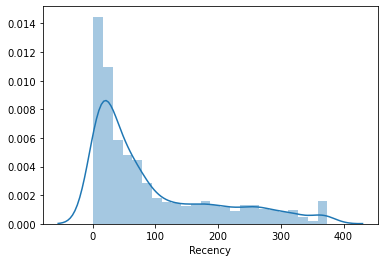

In [12]:
import seaborn as sns
sns.distplot(cust_df['Recency'])

<AxesSubplot:xlabel='Recency'>

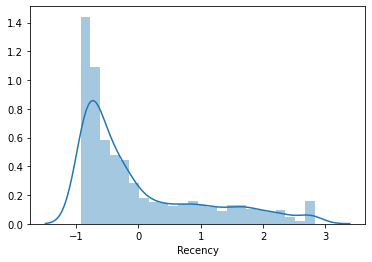

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
recency = scaler.fit_transform(cust_df['Recency'].values.reshape(-1,1))
cust_df.drop('Recency', axis=1, inplace=True)
cust_df.insert(0, 'Recency', recency)

sns.distplot(cust_df['Recency'])

<AxesSubplot:xlabel='Frequency'>

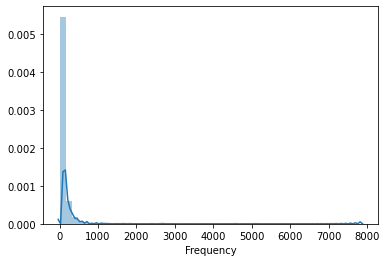

In [14]:
sns.distplot(cust_df['Frequency'])

<AxesSubplot:xlabel='Frequency'>

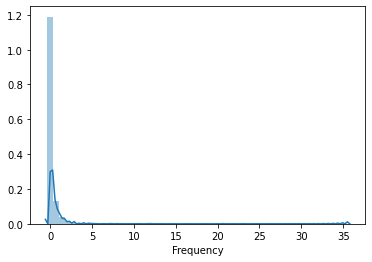

In [15]:
scaler = StandardScaler()
frequency = scaler.fit_transform(cust_df['Frequency'].values.reshape(-1,1))
cust_df.drop('Frequency', axis=1, inplace=True)
cust_df.insert(0, 'Frequency', frequency)

sns.distplot(cust_df['Frequency'])

<AxesSubplot:xlabel='Monetary'>

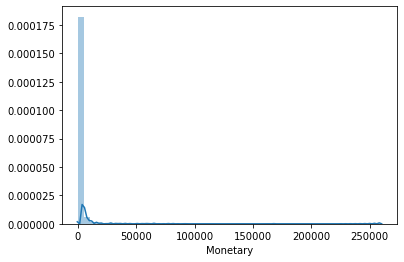

In [16]:
sns.distplot(cust_df['Monetary'])

<AxesSubplot:xlabel='Monetary'>

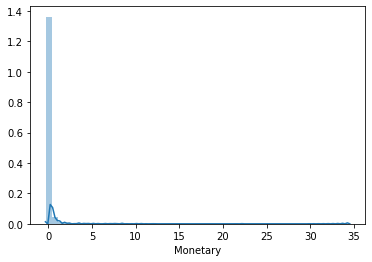

In [17]:
monetary = scaler.fit_transform(cust_df['Monetary'].values.reshape(-1,1))
cust_df.drop('Monetary', axis=1, inplace=True)
cust_df.insert(0, 'Monetary', monetary)

sns.distplot(cust_df['Monetary'])

## 실루엣 계수로 가장 적절한 군집 개수 구하기

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import math

def silhouette_clst(n):
    kmeans = KMeans(n_clusters=n, init='k-means++', max_iter=300,random_state=0).fit(cust_df.iloc[:,:4])
    cust_df['cluster']=kmeans.labels_
    score_samples = silhouette_samples(cust_df, cust_df['cluster'])
    cust_df['silhouette_coeff'] = score_samples
    average_score = silhouette_score(cust_df, cust_df['cluster'])
    print('평균 실루엣 계수:{0:.3f}'.format(average_score))
    print(cust_df.groupby('cluster')['silhouette_coeff'].mean())
    
    y_lower=10
    for i in range(n):
        ith_cluster_sil_values = cust_df.loc[cust_df['cluster']==i]['silhouette_coeff'].values
        ith_cluster_sil_values.sort()
        
        size_cluster_i = ith_cluster_sil_values.shape[0]
        y_upper = y_lower + size_cluster_i
            
        color = cm.nipy_spectral(float(i) / n)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                        facecolor=color, edgecolor=color, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
            
    plt.axvline(x=average_score, color="red", linestyle="--")
    plt.show()  

평균 실루엣 계수:0.623
cluster
0    0.624770
1    0.620554
Name: silhouette_coeff, dtype: float64


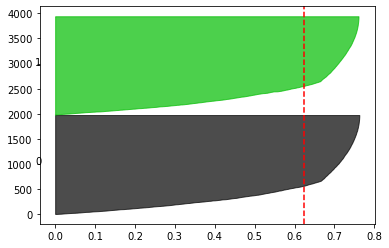

In [19]:
silhouette_clst(2)

평균 실루엣 계수:0.589
cluster
0    0.519047
1    0.625922
2    0.624962
Name: silhouette_coeff, dtype: float64


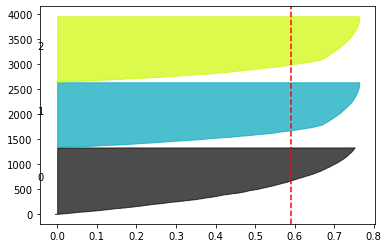

In [20]:
silhouette_clst(3)

평균 실루엣 계수:0.570
cluster
0    0.512051
1    0.515506
2    0.627189
3    0.627445
Name: silhouette_coeff, dtype: float64


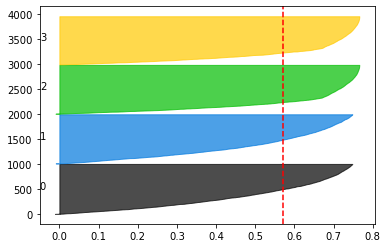

In [21]:
silhouette_clst(4)

평균 실루엣 계수:0.566
cluster
0    0.636391
1    0.521641
2    0.524728
3    0.628674
4    0.522992
Name: silhouette_coeff, dtype: float64


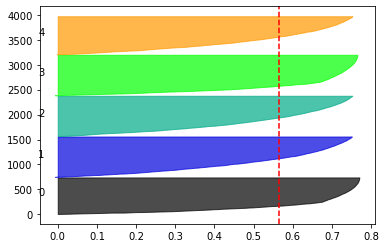

In [22]:
silhouette_clst(5)

평균 실루엣 계수:0.554
cluster
0    0.521739
1    0.518840
2    0.511731
3    0.627800
4    0.514628
5    0.629880
Name: silhouette_coeff, dtype: float64


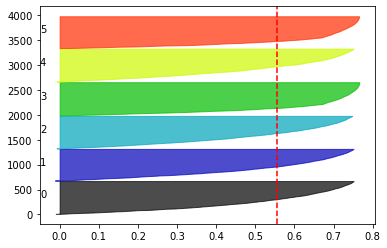

In [23]:
silhouette_clst(6)

평균 실루엣 계수:0.547
cluster
0    0.509109
1    0.510644
2    0.512344
3    0.630286
4    0.624847
5    0.521404
6    0.521103
Name: silhouette_coeff, dtype: float64


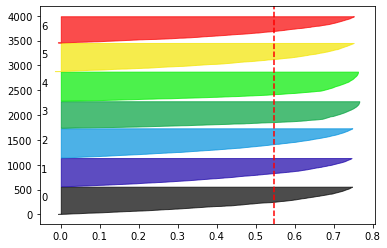

In [24]:
silhouette_clst(7)

평균 실루엣 계수:0.546
cluster
0    0.516126
1    0.622358
2    0.621367
3    0.535323
4    0.518335
5    0.512678
6    0.528958
7    0.513699
Name: silhouette_coeff, dtype: float64


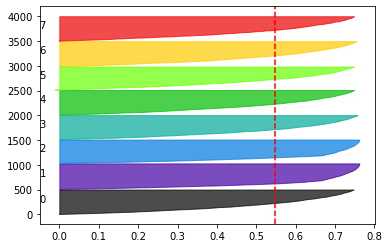

In [25]:
silhouette_clst(8)

실루엣 계수 비교만을 통해서 평가하자면, 2개의 군집으로 나눌 때 가장 실루엣 계수가 높게 나타난다.